In [1]:
import os
import torch
from tqdm import tqdm
from glob import glob
import itertools
from facelandmarks.config import *
from facelandmarks.cropping import *
from facelandmarks.landmarks_utils import *
from facelandmarks.preprocessing import *
from facelandmarks.face_landmarking_model import *
from facelandmarks.training import *

In [2]:
preprocess_data(target_folder="preprocessed_data", data_folders=['data/AI_Morphometrics', 'data/PHABRNO_pro_ML'])

  0%|          | 0/61 [00:00<?, ?it/s]

 38%|███▊      | 23/61 [05:32<20:34, 32.49s/it]

Skipped image in: data/AI_Morphometrics/Mauri_2019/muzi_enface.
Skipped image in: data/AI_Morphometrics/Mauri_2019/muzi_enface.
Skipped image in: data/AI_Morphometrics/Mauri_2019/muzi_enface.


 39%|███▉      | 24/61 [05:32<14:06, 22.89s/it]

Preprocessing went wrong in image: data/AI_Morphometrics/Mauri_2019/zeny_enface/_CZE8309.jpg, error: object of type 'NoneType' has no len().
Preprocessing went wrong in image: data/AI_Morphometrics/Mauri_2019/zeny_enface/_CZE8372.jpg, error: object of type 'NoneType' has no len().


 59%|█████▉    | 36/61 [11:39<18:51, 45.25s/it]

Preprocessing went wrong in image: data/AI_Morphometrics/SENEGAL_2021_selection/Bassari/MUZI_enface/_SEN9405.jpg, error: cannot unpack non-iterable NoneType object.


100%|██████████| 61/61 [22:16<00:00, 21.92s/it]

(5700, 956)
(5700, 144)
5700
(5700,)


In [2]:
results = {}
projectors = [3]
rotations = [True]
learning_rates = [0.01]
start_out_channels = [8]
num_parents = [10]
ffn_bias = [False]
kernel_sizes = [[3,3,3]]
crop_size = [35]
pooling = [['max', 'avg']]

hyperparameter_combinations = list(itertools.product(projectors,
                                                     rotations,
                                                     learning_rates,
                                                     num_parents,
                                                     start_out_channels,
                                                     ffn_bias,
                                                     kernel_sizes,
                                                     crop_size,
                                                     pooling))
i = 0
for num_projectors, rotate, lr, num_parent_landmarks, start_out_channels, ffn_bias, kernel_sizes, crop_size, pooling in tqdm(hyperparameter_combinations):
    combination = f"{num_projectors}_{rotate}_{lr}_{num_parent_landmarks}_{start_out_channels}_{ffn_bias}_{kernel_sizes}_{crop_size}_{pooling}"
    model, optimizers, schedulers, datasets, dataloaders = prepare_trainers(num_parent_landmarks=num_parent_landmarks, 
                                                                            projectors=num_projectors, 
                                                                            rotate=rotate, 
                                                                            lr_projection=0.01,
                                                                            lr_cnn=0.25,
                                                                            lr_ffn=lr,
                                                                            start_out_channels=start_out_channels,
                                                                            kernel_sizes=kernel_sizes,
                                                                            activations=False,
                                                                            pooling=pooling,
                                                                            crop_size=crop_size,
                                                                            batch_norm=False,
                                                                            num_cnn=4
                                                                            )
    cache = new_cache() 
    results[combination] = train(
                            model,
                            cache,
                            optimizers,
                            schedulers, 
                            datasets, 
                            dataloaders, 
                            pretrain_epochs=0,
                            cnn_epochs=0,
                            ffn_epochs=0,
                            all_train_epochs=0
                            )
                

  0%|          | 0/1 [00:00<?, ?it/s]

Preparing masks ...
Preparing model, optimizers, datasets and dataloaders...


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Start training!


In [ ]:
schedulers["cnn"].get_last_lr()

In [3]:
datasets['main'].work = False

./AI_Morphometrics/CMR_12/F_A_Cameroon/086_DSC0552.jpg


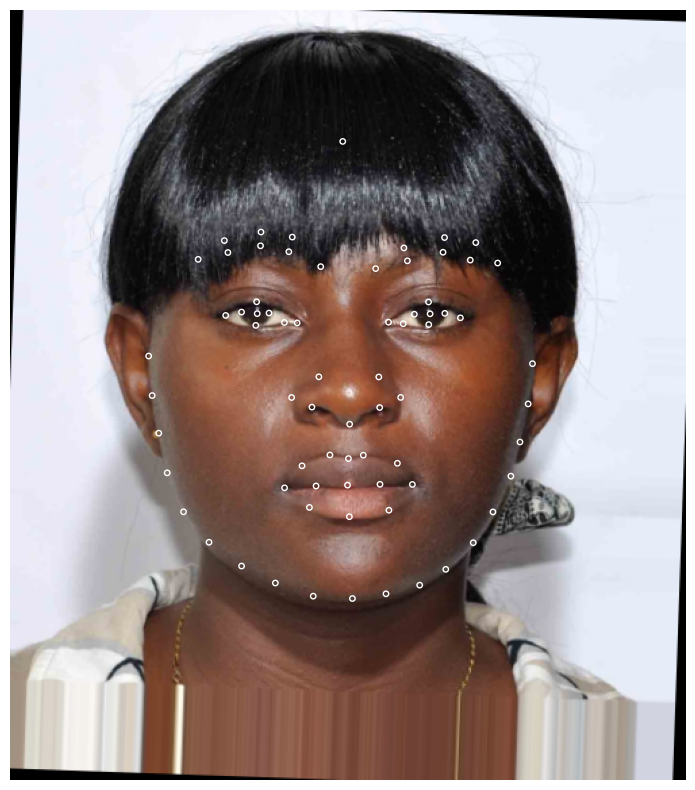

In [81]:
dataset = datasets['main']
dataset.pretraining = False
dataset.work = True
idx = torch.randint(dataset.__len__(),(1,))
batch = dataset.__getitem__(idx)
print(dataset.path_list[idx])
x, y, multicrop, subimage , image = batch
output, input, subimage = model.predict(image, precrop=False)
display_landmarks(y.reshape(-1,2), subimage, pixel_scale=False, origin='upper_left')

In [ ]:
results[combination] = train(
                        model,
                        cache,
                        optimizers,
                        schedulers, 
                        datasets, 
                        dataloaders, 
                        pretrain_epochs=0,
                        cnn_epochs=3,
                        ffn_epochs=0,
                        all_train_epochs=0
                        )

In [4]:
import plotly.graph_objs as go
import plotly.express as px

fig = go.Figure()

# for combination, losses in results.items():
for i in range(1):
    scatter = go.Scatter(
        x=list(range(len(cache['pretrain_cache'])))[50:],
        y=cache['pretrain_cache'][50:],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [5]:
import plotly.graph_objs as go
import plotly.express as px
fig = go.Figure()

# for combination, losses in results.items():
for i in range(1):
    scatter = go.Scatter(
        x=list(range(len(cache['test_cache']))),
        y=cache['test_cache'],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [6]:
import plotly.graph_objs as go
import plotly.express as px
fig = go.Figure()

# for combination, losses in results.items():
for i in range(1):
    scatter = go.Scatter(
        x=list(range(len(cache['improvements_cache']))),
        y=cache['improvements_cache'],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [ ]:
import plotly.graph_objs as go
import plotly.express as px
fig = go.Figure()

scatter = go.Scatter(
    x=list(range(len(cache['lr']))),
    y=cache['lr'],
    mode='lines',
    name=combination,
    hovertext=combination
    )

fig.add_trace(scatter)

fig.show()

In [ ]:
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

torch.save(model.state_dict(), model_dir + '/saved_model.pt')

In [ ]:
# Load the model
loaded_model = FaceLandmarking()
model_dir = 'model'
loaded_model.load_state_dict(torch.load(model_dir + '/saved_model.pt'))

# Set the model to evaluation mode
loaded_model.eval()
loaded_model.train_phase = 1

In [ ]:
dataset = datasets['main']
dataset.pretraining = False
dataset.work = True


idx = torch.randint(dataset.__len__(),(1,))
image_path = dataset.path_list[idx]
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
output, input, image = loaded_model.predict(image)
display_landmarks(output, image, pixel_scale=True, origin='upper_left')
print(output)

In [ ]:
loaded_model.train_phase